# Stock prices forecasting with LSTM, day-by-day rolling predictions
## 1. Import libraries

In [38]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import datetime as dt
import plotly.graph_objects as go


from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Stock apis
from alpha_vantage.timeseries import TimeSeries

import constants as c

## 2. Preprocessing
Data is obtained from AlphaVantage from 2015 to 2019 (inclusive). AlphaVantage is used instead of Polygon as it provides historical data beyond 2 years

In [68]:
# Get data from api
data, meta = TimeSeries(key=c.ALPHA_APIKEY, output_format='pandas').get_daily_adjusted(symbol='aapl', outputsize='full')
df = pd.DataFrame(data)

# Remove dates outside 2015-2019
df = df[(df.index >= pd.Timestamp('2015-01-01')) & (df.index <= pd.Timestamp('2019-12-30'))]
# Rename columns for easier access, remove unneccesary columns
df.rename({"1. open": "open",
           "2. high": "high",
           "3. low": "low",
           "4. close": "close",
           "6. volume": "volume"}, axis='columns', inplace=True)
df.drop(columns=["5. adjusted close", "7. dividend amount", "8. split coefficient"], inplace=True)
df['change'] = df['close'] - df['open']
df

,open,high,low,close,volume,change
date,,,,,,
2019-12-30,289.46,292.69,285.220,291.52,36059614.0,2.06
2019-12-27,291.12,293.97,288.120,289.80,36592936.0,-1.32
2019-12-26,284.82,289.98,284.700,289.91,23334004.0,5.09
2019-12-24,284.69,284.89,282.920,284.27,12119714.0,-0.42
2019-12-23,280.53,284.25,280.370,284.00,24677883.0,3.47
...,...,...,...,...,...,...
2015-01-08,109.23,112.15,108.700,111.89,59364547.0,2.66
2015-01-07,107.20,108.20,106.695,107.75,40105934.0,0.55
2015-01-06,106.54,107.43,104.630,106.26,65797116.0,-0.28


In [69]:
# Plot candle stick
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])

fig.show()

For our model, we will use only the closing prices. 

In [71]:
# Drop all columns except for closing price and date (index)
close_df = df[['close']]
close_df

,close
date,
2019-12-30,291.52
2019-12-27,289.80
2019-12-26,289.91
2019-12-24,284.27
2019-12-23,284.00
...,...
2015-01-08,111.89
2015-01-07,107.75
2015-01-06,106.26


As stock price is a time series data, the order of the data is important. We cannot randomize the dates. We will take stock prices from the years 2015-2018 (inclusive) to be our training set and stock prices from the year 2019 to be our test set

In [73]:
# Prepare training set
train_df = close_df['2015-01-01':'2018-12-30']

# Normalise data
scaler = MinMaxScaler(feature_range=(0,1))      # Explore using StandardScaler instead of MinMaxScaler in the future
scaled_data = scaler.fit_transform(train_df['close'].values.reshape(-1,1))

# Number of days to base prediction on:
N_PRED_DAYS = 50

x_train, y_train = [], []

for i in range(len(scaled_data) - N_PRED_DAYS):
    x_train.append(scaled_data[i:i+N_PRED_DAYS, 0])
    y_train.append(scaled_data[i+N_PRED_DAYS, 0])


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

x_train, y_train

/var/folders/hw/wb159grn5vqfnk074jgc32h00000gn/T/ipykernel_30901/4070833607.py:2: FutureWarning:

Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.



(array([[[0.46489805],
         [0.46433359],
         [0.47153037],
         ...,
         [0.90996966],
         [0.88675651],
         [0.92323432]],
 
        [[0.46433359],
         [0.47153037],
         [0.39857475],
         ...,
         [0.88675651],
         [0.92323432],
         [0.93000776]],
 
        [[0.47153037],
         [0.39857475],
         [0.42609186],
         ...,
         [0.92323432],
         [0.93000776],
         [0.89621111]],
 
        ...,
 
        [[0.26215339],
         [0.26903267],
         [0.25894306],
         ...,
         [0.15289635],
         [0.15204967],
         [0.1228392 ]],
 
        [[0.26903267],
         [0.25894306],
         [0.24419671],
         ...,
         [0.15204967],
         [0.1228392 ],
         [0.11232625]],
 
        [[0.25894306],
         [0.24419671],
         [0.234601  ],
         ...,
         [0.1228392 ],
         [0.11232625],
         [0.1122557 ]]]),
 array([0.93000776, 0.89621111, 0.92972553, 0.87567911,

## 3. Build LSTM model


In [74]:
def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    return model

## 4. Train the model

In [75]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')

2023-03-16 17:37:09.120886: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [76]:
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', 
                               verbose = 2, 
                               save_best_only = True,
                               monitor='loss'
                               )

hist = model.fit(x_train, 
          y_train, 
          epochs=35, 
          batch_size = 32,
          callbacks = [checkpointer])



Epoch 1/35
30/30 [==============================] - ETA: 0s - loss: 0.0260
Epoch 1: loss improved from inf to 0.02595, saving model to weights_best.hdf5
30/30 [==============================] - 7s 66ms/step - loss: 0.0260
Epoch 2/35
30/30 [==============================] - ETA: 0s - loss: 0.0036
Epoch 2: loss improved from 0.02595 to 0.00361, saving model to weights_best.hdf5
30/30 [==============================] - 3s 89ms/step - loss: 0.0036
Epoch 3/35
30/30 [==============================] - ETA: 0s - loss: 0.0033
Epoch 3: loss improved from 0.00361 to 0.00333, saving model to weights_best.hdf5
30/30 [==============================] - 2s 79ms/step - loss: 0.0033
Epoch 4/35
30/30 [==============================] - ETA: 0s - loss: 0.0033
Epoch 4: loss improved from 0.00333 to 0.00330, saving model to weights_best.hdf5
30/30 [==============================] - 2s 75ms/step - loss: 0.0033
Epoch 5/35
30/30 [==============================] - ETA: 0s - loss: 0.0030
Epoch 5: loss improved fr

## 5. Predictions

In [77]:
# Prepare test dataset (2019)
test_df = close_df['2019-01-01':]
actual_prices = test_df['close'].values

model_inputs = close_df[len(train_df) - N_PRED_DAYS:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

/var/folders/hw/wb159grn5vqfnk074jgc32h00000gn/T/ipykernel_30901/3287883075.py:2: FutureWarning:

Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.



In [78]:
x_test = []

for i in range(len(model_inputs) - N_PRED_DAYS):
    x_test.append(model_inputs[i:i+N_PRED_DAYS, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

8/8 [==============================] - 1s 18ms/step


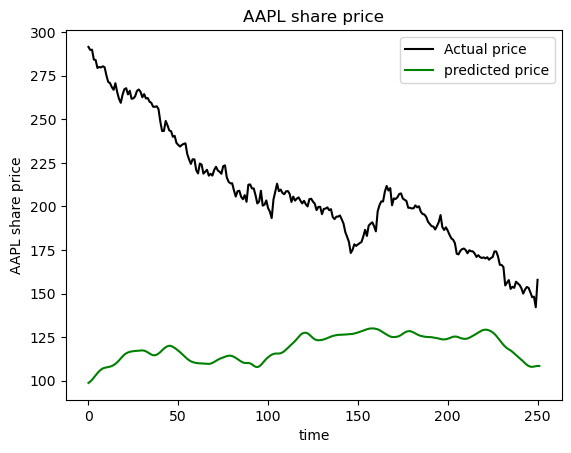

In [79]:
# Plot predicted prices
plt.plot(actual_prices, color='black', label=f"Actual price")
plt.plot(predicted_prices, color= 'green', label=f"predicted price")
plt.title("AAPL share price")
plt.xlabel("time")
plt.ylabel("AAPL share price")
plt.legend()
plt.show()